# DAY 8: Model Interpretation and data manipulation

### Machine Learning and Computational Statistics (DSC6232)

#### Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas

#### Due: August 3rd, 2:00 pm Kigali Time

**First name**: LONGIN

**Last name**: DUSENGEYEZU

**ID**:220020609

## Learning Goals:

1. encode non-numerical data
2. preprocess data: scaling covariates, outlier removal and data imputation
3. model interpretation for down-stream application

### Load necessary libraries

In [ ]:
# as usual, let us load all the necessary libraries
import numpy as np  # numerical computation with arrays
import pandas as pd # library to manipulate datasets using dataframes
import scipy as sp  # statistical library

# below sklearn libraries for different models
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# plot 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### We include auxiliary functions here that we will need to use later 

**No need to read in details!**

In [ ]:
# function to generate random splits
def split_data(X, y ,seed=29):
    ''' Function to split  randomly your dataset in train and test '''
    N,D = X.shape
    test_size=0.4
    np.random.seed(seed)
    permuted_idxs = np.random.permutation(N)
    N_train = int(np.floor(N*(1-test_size)))
    train_idxs = permuted_idxs[:N_train]
    test_idxs = permuted_idxs[N_train:]
    X_train = X[train_idxs,:]
    X_test = X[test_idxs,:]
    y_train = y[train_idxs]
    y_test = y[test_idxs]
    return X_train, X_test, y_train, y_test

# function to print feature importances (size of coefficients)
def print_sorted_feat_importance(weights, colnames):
    feature_weights = pd.Series(weights, index=colnames)
    feature_weights_sorted = feature_weights.apply(np.abs).sort_values(ascending=False)

    for name in feature_weights_sorted.index:
         print('{:23s}: {:.4f}'.format(name, feature_weights[name]))
            
# function to plot confidence intervals
def plot_confidence_intervals(bootstrap_weights, ax):
    rows = bootstrap_weights.shape[0]
    columns = bootstrap_weights.shape[1]
    bootstrap_weights = bootstrap_weights.reshape((rows, columns))
    ax.set_title("Variation in weight across variations in train set")
    ax.boxplot(bootstrap_weights)
    ax.set_ylabel('Weight values')
    ax.set_xlabel('Features')
    ax.set_xticklabels(X_colnames, rotation=90)
    return ax

# function to plot predictive intervals
def plot_predictive_intervals(bootstrap_predictions, labels, ax):
    rows = bootstrap_predictions.shape[0]
    columns = bootstrap_predictions.shape[1]
    bootstrap_predictions = bootstrap_predictions.reshape((rows, columns))
    ax.set_title("Variation in prediction across variations in train set")
    ax.boxplot(bootstrap_predictions)
    ax.set_ylabel('Predicted Sales')
    ax.set_xlabel('Companies')
    ax.set_xticklabels(labels, rotation=90)
    return ax

def get_data(messy_data=True):

    # load the data using pandas
    X_df = pd.read_csv('https://raw.githubusercontent.com/onefishy/Rwanda-course-2020/master/In-class/X.csv')
    y_df = pd.read_csv('https://raw.githubusercontent.com/onefishy/Rwanda-course-2020/master/In-class/y.csv')

    # change $ to cents
    
    X_df['bus_stops ($)'] *= 100.0
    X_df.rename(columns={'bus_stops ($)': 'bus_stops (cents)'}, inplace=True)
   
    # add id
    X_df['company id number'] = np.arange(X_df.shape[0])

    # add country
    r = X_df['TV ($)']
    r += np.random.normal(scale=2.0, size=r.shape)
    X_df['Country'] = r
    X_df.loc[r < 25.0, 'Country'] = 'Mexico'
    X_df.loc[(r > 25.0) & (r < 160.0), 'Country'] = 'USA'
    X_df.loc[r > 160.0, 'Country'] = 'Rwanda'

    X_df['Nationality'] = r
    X_df.loc[r < 25.0, 'Nationality'] = 'Mexican'
    X_df.loc[(r > 25.0) & (r < 160.0), 'Nationality'] = 'American'
    X_df.loc[r > 160.0, 'Nationality'] = 'Rwandan'


    if messy_data:    
        # create outliers
        p_outliers = 0.1
        outlier_idx = X_df.sample(frac=p_outliers, replace=True).index
        X_outliers = X_df.iloc[outlier_idx].copy()
        X_outliers[['electricity (mega W)', 'water (10^3 m3)']] += 30.0
        X_df = pd.concat([X_df, X_outliers], ignore_index=True)
        y_df = pd.concat([y_df, y_df.iloc[outlier_idx]], ignore_index=True)

        # add missing values
        p_missing_per_columnn = 0.01
        for c in X_df.columns:
            missing_idx = X_df.sample(frac=p_missing_per_columnn, replace=False).index
            X_missing = X_df.iloc[missing_idx].copy()
            X_missing[c] = np.NaN

            X_df = pd.concat([X_df, X_missing], ignore_index=True)
            y_df = pd.concat([y_df, y_df.iloc[missing_idx]], ignore_index=True)

    new_index = np.random.permutation(X_df.index)
    X_df = X_df.reindex(new_index)
    y_df = y_df.reindex(new_index)

    return X_df, y_df

---

## Predicting total sales from marketing strategy

In this exercise, you are asked to build a machine learning model to predict the total sales of a company based on their marketing strategy (how much money they invest in advertisement and in which venues they choose to advertise) as well as a few additional features of the company.

The goal is not only to predict how much sales a company should expect, the goal is to also make a recommendation to the company on how they should adjust their marketing strategy or internal operations (e.g. you might recommend, based on your model, that the company invests more in social media marketing).

#### Load the dataset and examine it

In [ ]:
# load the data using pandas
X_df, y_df = get_data()

In [ ]:
# print the first rows of the marketing strategies data
X_df.head()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),company id number,Country,Nationality
24,0.805950,2.194227,3364.974791,35.241950,12.327478,65.181941,12.6,18.3,24.0,USA,American
146,2.125383,1.380518,1562.070768,2.150076,19.467803,240.236336,7.3,8.7,146.0,Rwanda,Rwandan
149,1.585600,0.923946,3483.231230,15.573992,48.433076,46.832469,25.8,20.6,149.0,USA,American
44,2.339233,2.126285,3778.178962,18.378141,26.286682,23.577307,25.7,43.3,44.0,Mexico,Mexican
14,1.908918,1.870969,1082.428957,49.888656,35.972035,200.584604,32.9,46.0,14.0,Rwanda,Rwandan


**Exercise 1:** Are there any covariates we need to encode? If so, which ones?

**Answer**: Yes. 'Country' and 'Nationality' need encoding. Because they contain text data, so no way you can use text data in predicting model that predict numerical values, we need technics of encoding like one-hot encoding to encode that covariates('Country' and 'Nationality')  

In [ ]:
# print the first rows of the outcomes (total sales)
y_df.head()

,sales (10^3 units)
24,9.7
146,13.2
149,10.1
44,8.5
14,19.0


In [ ]:
# get a summary of how many rows in the dataset and how many missing values is in each column
# the 'Non-Null Count' counts the number of values in each column that is not missing
print(X_df.shape)
print(X_df.info())

(242, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 24 to 89
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   electricity (mega W)  240 non-null    float64
 1   water (10^3 m3)       240 non-null    float64
 2   bus_stops (cents)     239 non-null    float64
 3   sport_events ($)      240 non-null    float64
 4   social_media ($)      240 non-null    float64
 5   TV ($)                240 non-null    float64
 6   radio ($)             240 non-null    float64
 7   newspaper ($)         240 non-null    float64
 8   company id number     240 non-null    float64
 9   Country               240 non-null    object 
 10  Nationality           240 non-null    object 
dtypes: float64(9), object(2)
memory usage: 22.7+ KB
None


**Exercise 2:** How many companies are contained in this dataset? For each covariate or column in the dataset, how many values are missing?

**Answer**:
 According to the computation below, the total number of companies is 200 and for each column, only 2 values are missing from my result.
 
NB: when you run again result of null value could be change due to the randomness in dataset.


In [ ]:
unique_campa=X_df['company id number'].unique()
company_number= X_df.agg({"company id number": "nunique"})
print(company_number)
print(X_df.isnull().sum())

company id number    200
dtype: int64
electricity (mega W)    2
water (10^3 m3)         2
bus_stops (cents)       3
sport_events ($)        2
social_media ($)        2
TV ($)                  2
radio ($)               2
newspaper ($)           2
company id number       2
Country                 2
Nationality             2
dtype: int64


In [ ]:
# Check number of companies
n = pd.unique(X_df['company id number'])
n


array([ 24., 146., 149.,  44.,  14.,  46.,  40.,   2.,  45.,  38., 192.,
        96.,  10.,  17.,  72., 173., 140., 182., 133., 135.,  54.,  83.,
       152.,   4., 161., 122.,   9., 166.,  52.,  61., 115., 162.,  59.,
       174., 167.,  88., 194.,  41.,  92., 191.,  98., 106.,  36., 183.,
         6.,  91.,  81.,  39., 180.,  86.,  99., 179., 185., 114., 134.,
        68., 145., 128., 121.,  33.,  20., 153.,  82.,  16.,   3., 136.,
        32., 156., 142., 172., 124., 113.,  27., 110., 177.,  18., 163.,
        65., 186.,  31., 176.,  80., 125., 111., 131.,  97., 107., 103.,
       109., 112.,  25., 129., 148.,   0., 159.,  79.,  84., 130.,  12.,
        49., 144., 171., 104., 170.,  56.,  50., 108.,  78., 132., 126.,
       101., 197.,  nan,  74., 147.,  76.,  29., 184.,  62.,  66.,  67.,
       105., 123.,   1., 100.,  34., 165., 188., 189.,  60.,  15., 190.,
        30.,  47., 196.,  90.,  19.,  22., 120.,   8., 187.,  35., 151.,
        87., 143.,  77.,  58.,  26., 127.,  94., 13

In [ ]:
# print a summary of the values for each covariate in the dataset
X_df.describe()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),company id number
count,240.000000,240.000000,239.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,4.429580,4.553451,2511.432707,25.221995,24.286494,145.075564,23.396250,31.257083,99.500000
std,9.043629,8.989447,1422.461675,15.172385,13.847237,86.852469,15.027418,21.612751,59.607994
min,0.041303,0.105909,68.892921,0.226549,0.010645,0.639647,0.000000,0.300000,0.000000
25%,0.829399,0.960950,1293.493718,12.777181,12.676538,67.671555,9.825000,13.625000,46.750000
50%,1.495832,1.536288,2432.286812,24.974554,24.060339,150.691237,22.900000,26.300000,102.500000
75%,2.376239,2.454275,3637.722595,38.174331,34.787002,219.285732,36.900000,45.100000,151.250000
max,32.852260,32.341130,4979.869199,49.888656,49.288811,297.678382,49.600000,114.000000,199.000000


**Exercise 3:** Do we need to scale the covariates in this dataset? Why or why not?

**Answer**: Yes we do. The features have different scales which affect proper training time and interpretation of the model. For example, the feature 'bus_stops' is recorded in cents while the other monetary features are in dollars. There are also features which haver other units like "mega watts" and "m^3". That would be a major setback in our model fitting, if the data is not rescaled because different scales distorts the truthfulness and reliability of model parameters. Also higher difference in magnitude number can also affect proper training. 



---
## Pre-process the data

We apply one-hot encoding to  categorical covariates, scale the values in the covariates, impute missingness and remove outliers.

#### One-hot encode categorical variables

In [ ]:
# one hot encode the covariate 'Country'
one_hot_country = pd.get_dummies(X_df['Country'], prefix='Country')

# use pd.concat to join the new columns with your original dataframe
X_df = pd.concat([X_df, one_hot_country], axis=1)

# now drop the original 'country' column (you don't need it anymore)
X_df.drop(['Country'], axis=1, inplace=True)

# print the resultant dataframe
X_df.head()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),company id number,Nationality,Country_Mexico,Country_Rwanda,Country_USA
24,0.805950,2.194227,3364.974791,35.241950,12.327478,65.181941,12.6,18.3,24.0,American,0,0,1
146,2.125383,1.380518,1562.070768,2.150076,19.467803,240.236336,7.3,8.7,146.0,Rwandan,0,1,0
149,1.585600,0.923946,3483.231230,15.573992,48.433076,46.832469,25.8,20.6,149.0,American,0,0,1
44,2.339233,2.126285,3778.178962,18.378141,26.286682,23.577307,25.7,43.3,44.0,Mexican,1,0,0
14,1.908918,1.870969,1082.428957,49.888656,35.972035,200.584604,32.9,46.0,14.0,Rwandan,0,1,0


**Exercise 4:** Encode the remaining categorical variables.

In [ ]:
# Step 1: one hot encode the categorical covariate
one_hot_nationality = pd.get_dummies(X_df['Nationality'], prefix='Nationality')
# Step 2: use pd.concat to join the new columns with your original dataframe
X_df = pd.concat([X_df, one_hot_nationality], axis=1)
X_df.drop(['Nationality'], axis=1, inplace=True)

# print the resultant dataframe
X_df.head()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),company id number,Country_Mexico,Country_Rwanda,Country_USA,Nationality_American,Nationality_Mexican,Nationality_Rwandan
24,0.805950,2.194227,3364.974791,35.241950,12.327478,65.181941,12.6,18.3,24.0,0,0,1,1,0,0
146,2.125383,1.380518,1562.070768,2.150076,19.467803,240.236336,7.3,8.7,146.0,0,1,0,0,0,1
149,1.585600,0.923946,3483.231230,15.573992,48.433076,46.832469,25.8,20.6,149.0,0,0,1,1,0,0
44,2.339233,2.126285,3778.178962,18.378141,26.286682,23.577307,25.7,43.3,44.0,1,0,0,0,1,0
14,1.908918,1.870969,1082.428957,49.888656,35.972035,200.584604,32.9,46.0,14.0,0,1,0,0,0,1


**Exercise 5:** Inspect your DataFrame, are there any covariates that are irrelevant for prediction $y$? Drop unimportant covariates. 

***Hint:*** does the id number of the compny help predict total revenue?

Are there any covariates that are redundant, i.e. they contain the exact information as other covariates? Drop redundant covariates.

**Answer**: 
The dataFrame was inspected and the 'company id number' was found to be the only variable which is irrelevant for prediction of y. Apparently, it is only used to provide indenties for the companies which is already accomplished by the index, thus making it unimportant in our dataFrame and also we find that ‘Country and Nationality ‘ are redundant one need to be removed and we have decided to remove nationality variable.
 the columns was dropped using the code below.


In [ ]:
# Step 1: Drop unimportant covariates
# Hint: look up the documentation for pandas' .drop() function
# COMPLETE
X_df.drop(columns=['company id number'],inplace=True)

# Step 2: Drop ALL redundant covariates
# Hint: look up the documentation for pandas' .drop() function
# COMPLETE
X_df.drop(columns=['Nationality_American','Nationality_Mexican','Nationality_Rwandan'],inplace=True)

#### Impute missing values

**Exercise 5:** Impute the missing values in each column using a k-Nearest Neighbor model.

**Algorithm description**:The idea in kNN methods is to identify 'k' samples in the dataset that are similar or close in the space. Then we use these 'k' samples to estimate the value of the missing data points. Each sample's missing values are imputed using the mean value of the 'k'-neighbors found in the dataset.

as you can see X_df.isnull().sum() return zeros for each variable means that all Missing value was filled by KNNimpute.

In [ ]:
# Step 1: define an knn imputer using KNNImputer
# Hint: look up the documentation for KNNImputer
# COMPLETE
imputer = KNNImputer(n_neighbors=10)

# Step 2: impute the missing data
X_df = pd.DataFrame(imputer.fit_transform(X_df), columns=X_df.columns, index=X_df.index)
X_df.isnull().sum()

electricity (mega W)    0
water (10^3 m3)         0
bus_stops (cents)       0
sport_events ($)        0
social_media ($)        0
TV ($)                  0
radio ($)               0
newspaper ($)           0
Country_Mexico          0
Country_Rwanda          0
Country_USA             0
dtype: int64

#### Remove outliers

**Exercise 6:** Remove the outlier values in each column of the dataset.

**description**

Outlier affect our model prediction so, we need same technics to remove all values deviate highly our data 

 Codes for outlier removal were implemented and run as per the work below. Evidently, the highest proportion of the data points were not positioned centrally. Over 50% of the rows were removed since they were lower than 5th percentile and above 95th percentile. This technically means that the removed proportion of data was not centrally placed, hence considering them as outliers.


In [ ]:
low = .05
high = .95
# Step 1: compute 5% percentile and the 95% percentile of each column in the dataset
quantile_df = X_df.quantile([low, high])
quantile_df

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),Country_Mexico,Country_Rwanda,Country_USA
0.05,0.175489,0.395286,393.365765,2.126516,3.816378,14.078267,2.10,4.05,0.0,0.0,0.0
0.95,31.195143,31.236773,4744.333038,48.484092,47.789942,278.114739,46.39,71.80,1.0,1.0,1.0


In [ ]:
# Step 2: remove ouliers in 'water (10^3 m3)'

# print the number of rows before outlier removal
print('Number of rows before outlier removal: {}'.format(X_df.shape[0]))
# select rows greater than the 5% and smaller than the 95% threshold
X_df = X_df[(X_df['water (10^3 m3)'] > quantile_df.loc[0.05, 'water (10^3 m3)']) & (X_df['water (10^3 m3)'] < quantile_df.loc[0.95, 'water (10^3 m3)'])]
# print the number of rows after outlier removal
print('Number of rows after outlier removal: {}'.format(X_df.shape[0]))

Number of rows before outlier removal: 242
Number of rows after outlier removal: 216


In [ ]:
#X_df1 = X_df.apply(lambda x: x[(x>quantile_df.loc[low,x.name]) & 
                                    #(x < quantile_df.loc[high,x.name])], axis=0)
#X_df1


In [ ]:
# Step 3: perform outlier removal for all columns
# COMPLETE

X_df = X_df[(X_df['electricity (mega W)'] > quantile_df.loc[0.05, 'electricity (mega W)']) & (X_df['electricity (mega W)'] < quantile_df.loc[0.95, 'electricity (mega W)'])]
X_df = X_df[(X_df['bus_stops (cents)'] > quantile_df.loc[0.05, 'bus_stops (cents)']) & (X_df['bus_stops (cents)'] < quantile_df.loc[0.95, 'bus_stops (cents)'])]
X_df = X_df[(X_df['sport_events ($)'] > quantile_df.loc[0.05, 'sport_events ($)']) & (X_df['sport_events ($)'] < quantile_df.loc[0.95, 'sport_events ($)'])]
X_df = X_df[(X_df['social_media ($)'] > quantile_df.loc[0.05, 'social_media ($)']) & (X_df['social_media ($)'] < quantile_df.loc[0.95, 'social_media ($)'])]
X_df = X_df[(X_df['TV ($)'] > quantile_df.loc[0.05, 'TV ($)']) & (X_df['TV ($)'] < quantile_df.loc[0.95, 'TV ($)'])]
X_df = X_df[(X_df['radio ($)'] > quantile_df.loc[0.05, 'radio ($)']) & (X_df['radio ($)'] < quantile_df.loc[0.95, 'radio ($)'])]
X_df = X_df[(X_df['newspaper ($)'] > quantile_df.loc[0.05, 'newspaper ($)']) & (X_df['newspaper ($)'] < quantile_df.loc[0.95, 'newspaper ($)'])]

X_df = X_df[(X_df['radio ($)'] > quantile_df.loc[0.05, 'radio ($)']) & (X_df['radio ($)'] < quantile_df.loc[0.95, 'radio ($)'])]
X_df


,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),Country_Mexico,Country_Rwanda,Country_USA
24,0.805950,2.194227,3364.974791,35.241950,12.327478,65.181941,12.6,18.3,0.0,0.0,1.0
146,2.125383,1.380518,1562.070768,2.150076,19.467803,240.236336,7.3,8.7,0.0,1.0,0.0
44,2.339233,2.126285,3778.178962,18.378141,26.286682,23.577307,25.7,43.3,1.0,0.0,0.0
46,1.025859,1.291973,1558.575010,19.517553,16.135910,87.090026,9.9,35.7,0.0,0.0,1.0
45,0.524209,1.942389,1427.385412,5.017469,44.768665,172.447052,22.5,31.5,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
181,1.978035,1.936167,3239.150235,43.469991,41.806052,214.452528,5.4,27.4,0.0,1.0,0.0
47,0.433793,1.225361,1084.423209,30.003101,5.503025,236.712998,41.5,18.5,0.0,1.0,0.0
86,2.844898,0.474810,2665.764731,9.599912,38.629133,77.219716,27.5,16.0,0.0,0.0,1.0
164,1.510529,1.670866,1150.755604,25.251259,26.432076,118.180180,14.7,5.4,0.0,0.0,1.0


#### Scale the data

**Exercise 7:** Scale the values of the covariates so that they all lie in the range of $[0, 1]$. 

In [ ]:
# Step 1: define a MinMax scalar that will transform the data values into values in (0, 1)
# Hint: Look up the documentation for MinMaxScaler
# COMPLETE
# scaler = ...
scalar = MinMaxScaler()


# Step 2: fit the MinMaxScaler using our data 
# Hint: use .fit()
scalar.fit(X_df)
# COMPLETE
X_values = X_df.values
# Step 3: scale the values in our dataset, X_values 
# Hint: use .transform()
# COMPLETE
X_values_scaled = scalar.transform(X_df)
X_df = pd.DataFrame(X_values_scaled, columns=X_df.columns)
X_df


,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),Country_Mexico,Country_Rwanda,Country_USA
0,0.019685,0.056535,0.681135,0.719988,0.185836,0.200615,0.229358,0.206843,0.0,0.0,1.0
1,0.063342,0.030091,0.253363,0.000000,0.352371,0.904168,0.107798,0.057543,0.0,1.0,0.0
2,0.070418,0.054327,0.779176,0.353078,0.511409,0.033403,0.529817,0.595645,1.0,0.0,0.0
3,0.026962,0.027214,0.252534,0.377868,0.274661,0.288665,0.167431,0.477449,0.0,0.0,1.0
4,0.010363,0.048351,0.221407,0.062387,0.942468,0.631719,0.456422,0.412131,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
90,0.058467,0.048149,0.651281,0.899008,0.873371,0.800542,0.064220,0.348367,0.0,1.0,0.0
91,0.007372,0.025049,0.140033,0.606005,0.026668,0.890008,0.892202,0.209953,0.0,1.0,0.0
92,0.087149,0.000657,0.515235,0.162088,0.799275,0.248995,0.571101,0.171073,0.0,0.0,1.0
93,0.042998,0.039527,0.155771,0.502618,0.514800,0.413618,0.277523,0.006221,0.0,0.0,1.0


---
## Model the data

Now that we have preprocessed the data, we are ready to build models to predict the label $y$ using the covariates $X$.


#### Split the data into training and testing

In [ ]:
# transform the data into numpy arrays
X = X_df.values
y = y_df.values

# store the names of the columns
X_colnames = X_df.columns.values
y_colnames = y_df.columns.values

In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = split_data(X,y)
# name the companies in the test set
indices = ['company %d' % d for d in range(1,X_test.shape[0]+1)]
X_test_df = pd.DataFrame(X_test, columns=X_colnames, index=indices)

#### Train a linear regression model

**Exercise 8:** Train a linear regression model to predict the total sales $y$ from the marketing strategy data $X$. Evaluate the train and test MSE of you model. 

How is the fit of your model? Would you feel comfortable using this model to make real marketing decisions? Why or why not?

**Answer**: The model was fit and the two MSEs were computed. Actually, I would not trust this model and be comfortable to implement in real market problems because the both MSES are two high and the difference between then is not small. This simply means that bias is so prevalent in both testing and training which lowers generalization. Models with high generalization errors are not supposed to be used to solve sensitive problems like monetary issues. As observer from result of Test and Training error  this model cannot used to predict sales 

In [ ]:
# Step 1: create a sklearn linear regression model
# COMPLETE
linear_regressor = LinearRegression()

# Step 2: fit the linear regression model on the data
linear_regressor.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Step 3: compute MSE on train dataset
# COMPLETE
predict_train=linear_regressor.predict(X_train)
mse_train = mean_squared_error(y_train,predict_train)

# Step 4: compute MSE on test dataset
# COMPLETE
predict_test=linear_regressor.predict(X_test)
mse_test = mean_squared_error(y_test,predict_test)

print('MSE on train set: %.2f' % mse_train)
print('MSE on test set: %.2f' % mse_test)

MSE on train set: 24.09
MSE on test set: 33.94


**Exercise 9:** There are three subgroups of companies in your dataset, "USA", "Rwanda" and "Mexico". Evaluate the test MSE on each subgroup of companies in your dataset. 

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=X_colnames)
# Step 1: select all companies from Rwanda
country_is_rwanda = (X_test_df['Country_Rwanda'] == 1)
country_is_rwanda_train = (X_train_df['Country_Rwanda'] == 1)
country_is_USA = (X_train_df['Country_USA'] == 1)
country_is_usa_test = (X_test_df['Country_USA'] == 1)
country_is_Mexico = (X_train_df['Country_Mexico'] == 1)
country_is_usa_Mexico = (X_test_df['Country_Mexico'] == 1)

# Step 2: compute the test MSE for these companies
score_test_train = mean_squared_error(y_train[country_is_rwanda_train], linear_regressor.predict(X_train_df[country_is_rwanda_train]))
print('MSE on train set (Rwanda): %.2f' % score_test_train)
score_test = mean_squared_error(y_test[country_is_rwanda], linear_regressor.predict(X_test_df[country_is_rwanda]))
print('MSE on test set (Rwanda): %.2f' % score_test)
print("   ")

# Step 3: evaluate the train MSE for companies from the USA
# COMPLETE
score_test_train = mean_squared_error(y_train[country_is_USA], linear_regressor.predict(X_train_df[country_is_USA]))
print('MSE on train set (USA): %.2f' % score_test_train)
score_test_usa = mean_squared_error(y_test[country_is_usa_test], linear_regressor.predict(X_test_df[country_is_usa_test]))
print('MSE on test set (usa): %.2f' % score_test_usa)
print("   ")
# Step 4: evaluate the train MSE for companies from Mexico
# COMPLETE
score_train_test = mean_squared_error(y_train[country_is_Mexico], linear_regressor.predict(X_train_df[country_is_Mexico]))
print('MSE on train set (Mexico): %.2f' % score_train_test)
score_test_mexico = mean_squared_error(y_test[country_is_usa_Mexico], linear_regressor.predict(X_test_df[country_is_usa_Mexico]))
print('MSE on test set (mexico): %.2f' % score_test_mexico)

MSE on train set (Rwanda): 28.27
MSE on test set (Rwanda): 25.55
   
MSE on train set (USA): 21.78
MSE on test set (usa): 46.63
   
MSE on train set (Mexico): 0.00
MSE on test set (mexico): 30.65


**Exercise 10:** For which group of companies does your model do the best? For which group of companies does your model do the worst? Explain why your model does well on some groups but not others.

***Hint:*** Count the number of companies of each nationality.

**Answer**: When we look at test and training score mse and also number of companies in Rwanda are higeher,  the model does its best on Rwandan companies and its worst on Mexican. This is because there is a huge class imblance among the groups, theoretically, we know that minority classes do not perform better in a model because the dominants ones overpower them. That is why the minority class from Mexico has not been to been able to perform in the model while the other two dominant classes did better.

In [ ]:
# count the number of data rows that has a 1 in the 'Country_Rwanda' column
count_rwanda = X_df['Country_Rwanda'].sum()
print('Number of entries from Rwanda', count_rwanda)
count_us = X_df['Country_USA'].sum()
print('Number of entries from us', count_us)
count_Mexico = X_df['Country_Mexico'].sum()
print('Number of entries from Mexico', count_Mexico)

Number of entries from Rwanda 46.0
Number of entries from us 39.0
Number of entries from Mexico 8.0


---

## Interpret the model

Often, we are not just interested in obtaining a prediction from a model, we are also interested in why the model has made that prediction.

For a linear regression model, $y = w_0 + w_1x_1 + w_2x_2 + \ldots + w_Dx_D$, looking at the coefficients can help us determine which feature was an important factor in the prediction.

The coefficients of `sklearn`'s linear regression model is stored in the model's `.coef_` parameter.

**Exercise 11:** Based on your model coefficients, which feature do you think has the most effect on the total sales? Can you hypothesize why?

**Answer**:

 
The most effective is ' water (10^3 m3) and is affecting sales negatively sales’. Hypothetically, since most of the advertisement is supposed to be consuming too much water this can reduce sales. This mean that each company should look method of advertisement that is not consuming to much water   
 


In [ ]:
# Step 1: get the coefficients for the linear regression model
weights = linear_regressor.coef_[0]

# Step 2: print the coefficients in descending order (by absolute value)
print_sorted_feat_importance(weights, X_colnames)

water (10^3 m3)        : -21.6756
electricity (mega W)   : 19.3404
TV ($)                 : 5.6449
social_media ($)       : 4.5249
newspaper ($)          : -3.6027
Country_Mexico         : -2.5934
radio ($)              : 1.7520
Country_Rwanda         : -0.5489
Country_USA            : 0.5469
sport_events ($)       : -0.2444
bus_stops (cents)      : -0.0269


#### Constructing Confident Intervals for Regression Coefficients

Before we start making marketing recommendations based on the regression coefficients, let's determine if these coefficients are significant. That is, are the coefficients describing a rule that is particular only to our training data and cannot generalize to new data?

To do this, we change the training data slightly (by bootstrapping) and see how much our regression coefficients change.

**Exercise 12:** Based on the following box plot of the regression coefficient for models fitted on 5 bootstrapped training data sets, which feature do you think has the most effect on the total sales? Is this answer different from your answer in Exercise 1?

**Answer**: 
 According to the plots, feature 'social media' seems to be more effective than the others. The reason being the shortness of its box plot and the overlapping weights within the range of the plot. The shortness of the plot and the overlapping values of the coefficients over the bootstraps tells us how short it's confidence interval is, hats confidently being more effective than the others. And this is totally different to what I have seen in first exercise. But this one is the one that make sense in real life because as increase social media advertisement can also increase sales    


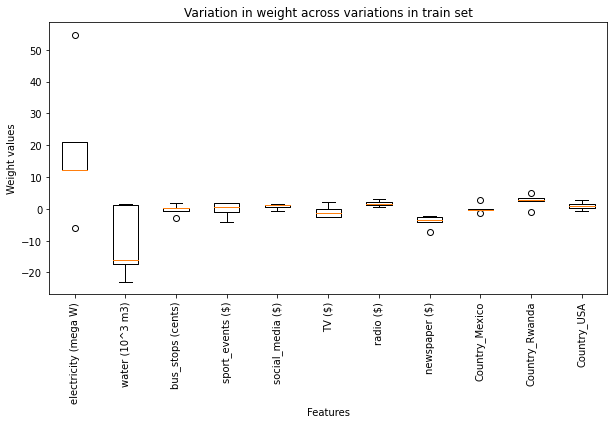

In [ ]:
# Step 1: Uncomment and run
# ### we fit 5 regression models on 5 bootstrapped samples of our training data
# # number of bootstrap samples to make
n_bootstrap = 5
# # a list to store the weights of each regression model
bootstrap_weights = []
for n in range(n_bootstrap):
     # create new training data
     X_train, _, y_train, _ = split_data(X, y, seed=n)
     # train linear regressor model
     linear_regressor.fit(X_train,y_train)
     # save the regression weights
     bootstrap_weights.append(linear_regressor.coef_[0])
    
bootstrap_weights = np.array(bootstrap_weights)

# # make a box plot for the regression weights
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_confidence_intervals(bootstrap_weights, ax)
plt.show()

#### Constructing the Predictive Interval of a Regression Model

In test data, company 30 is **Coca-cola** and company 29 is **Inyange**.

**Exercise 13:** Using your linear regression model predict which company will have a higher total sales based on their marketing strategy.

Construct the predictive interval for each predicted total sales. 

How confident are you in your predictions? Support your answers using concepts from lecture.

**Answer**:

company will have a higher total sales based on their marketing strategy is Coca-cola The predictive intervals were constructed and visualised by the plot below. Technically, I would not be confident in none of the predictions. This is simply because, as wide as the intervals are, none of the predictions could make it to the 5th or 95th percentiles of both box plots. This means that there were high variations in the predictions over the 1000 bootstraps. All the varing predictions fell outside the wide prediction intervals, thus making them unreliable.


In [ ]:
X_test_df.head()

,electricity (mega W),water (10^3 m3),bus_stops (cents),sport_events ($),social_media ($),TV ($),radio ($),newspaper ($),Country_Mexico,Country_Rwanda,Country_USA
company 1,0.029686,0.090833,0.376055,0.203223,0.599638,0.429047,0.133028,0.679627,0.0,0.0,1.0
company 2,0.063342,0.030091,0.253363,0.000000,0.352371,0.904168,0.107798,0.057543,0.0,1.0,0.0
company 3,0.087149,0.000657,0.515235,0.162088,0.799275,0.248995,0.571101,0.171073,0.0,0.0,1.0
company 4,0.007853,0.024098,0.089217,0.566153,0.751705,0.351198,0.619266,0.052877,0.0,0.0,1.0
company 5,0.058467,0.048149,0.651281,0.899008,0.873371,0.800542,0.064220,0.348367,0.0,1.0,0.0


In [ ]:
# Step 1: predict on the test data
# COMPLETE
y_predict = linear_regressor.predict(X_test_df)

# Step 2: get the 29th and 30th predictions
# COMPLETE
y_pred_29 = y_predict[29] 
y_pred_30 = y_predict[30]

# print the total sales of company 29 and company 30
print('Predicted sales for Coca-cola: %.2f (thousand units)' % y_pred_29)
print('Predicted sales for Inyange: %.2f (thousand units)' % y_pred_30)


Predicted sales for Coca-cola: 19.06 (thousand units)
Predicted sales for Inyange: 16.07 (thousand units)


Construct the predictive interval for each predicted total sales. Based on these intervals, how confident are you in your predictions?

**Answer**:
company will have a higher total sales based on their marketing strategy is Coca-cola The predictive intervals were constructed and visualised by the plot below. Technically, I would not be confident in none of the predictions. This is simply because, as wide as the intervals are, none of the predictions could make it to the 5th or 95th percentiles of both box plots. This means that there were high variations in the predictions over the 1000 bootstraps. All the varing predictions fell outside the wide prediction intervals, thus making them unreliable.


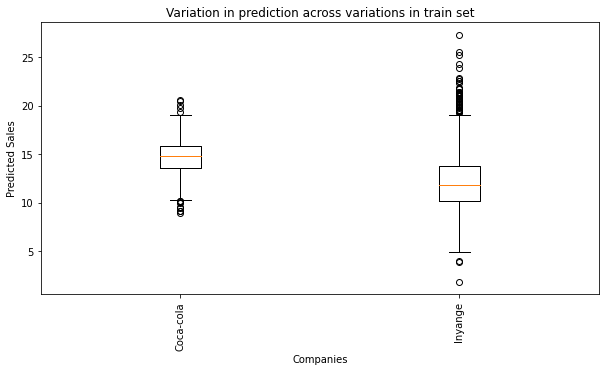

In [ ]:
# Step 1: Uncommnent and run
# ### we fit 1000 regression models on 1000 bootstrapped samples of our training data
n_bootstrap = 1000
# # make a list to store the predicted sales
bootstrap_y_pred = []
for n in range(n_bootstrap):
#     # make new data
     X_train, _, y_train, _ = split_data(X, y, seed=n)
    # train linear regression model
     linear_regressor.fit(X_train,y_train)
     # predict on company 30 and 31
     y_predict = linear_regressor.predict(X_test[29:31])
    # add the prediction to the list
     bootstrap_y_pred.append(y_predict)
# convert the list into an array
bootstrap_y_pred = np.array(bootstrap_y_pred)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_predictive_intervals(bootstrap_y_pred, ['Coca-cola', 'Inyange'], ax)
plt.show()